In [1]:
from scipy import stats
import statsmodels.api as sm
import statsmodels
# from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn import metrics

from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('bmh')

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))
    
def ts_metrics(y_true, y_pred):
    return {
        'mae': metrics.mean_absolute_error(y_true, y_pred),
        # 'mse': metrics.mean_squared_error(y_true, y_pred),
        # 'mape': np.mean(np.abs((y_true - y_pred) / y_true)),
        # 'smape': np.mean(np.abs( 2*(y_true - y_pred) / (y_true+np.abs(y_pred)))),
        # 'nmse':  np.sum((y_true - y_pred)**2) / np.sum((y_true)**2),
    }

### 0. Data

In [2]:
# Prepare dataset
df1 = pd.read_pickle('data/df_stat.pkl')
# print(df1.columns)
df1 = df1[df1.index > 2009].sort_index()

# fill 2020 and 2021
for f in df1.columns:
    df1.loc[df1.index == 2020, f] = np.nan
    df1.loc[df1.index == 2021, f] = np.nan
    df1[f] = (df1[f].fillna(method = 'bfill') + df1[f].fillna(method = 'ffill')) / 2

# select feature to predict
# feat = 'Deaths within 24 hours'
feat = 'Seriously injured'
df1 = df1.reset_index().rename(columns = {'Year': 'ds', feat: 'y'})[['ds','y']]

x = df1.set_index('ds').y
x

ds
2010   2,007.00
2011   1,866.00
2012   1,980.00
2013   1,901.00
2014   1,888.00
2015   1,900.00
2016   1,839.00
2017   1,711.00
2018   1,736.00
2019   1,689.00
2020   1,626.50
2021   1,626.50
2022   1,564.00
Name: y, dtype: float64

### 1. Stationarity

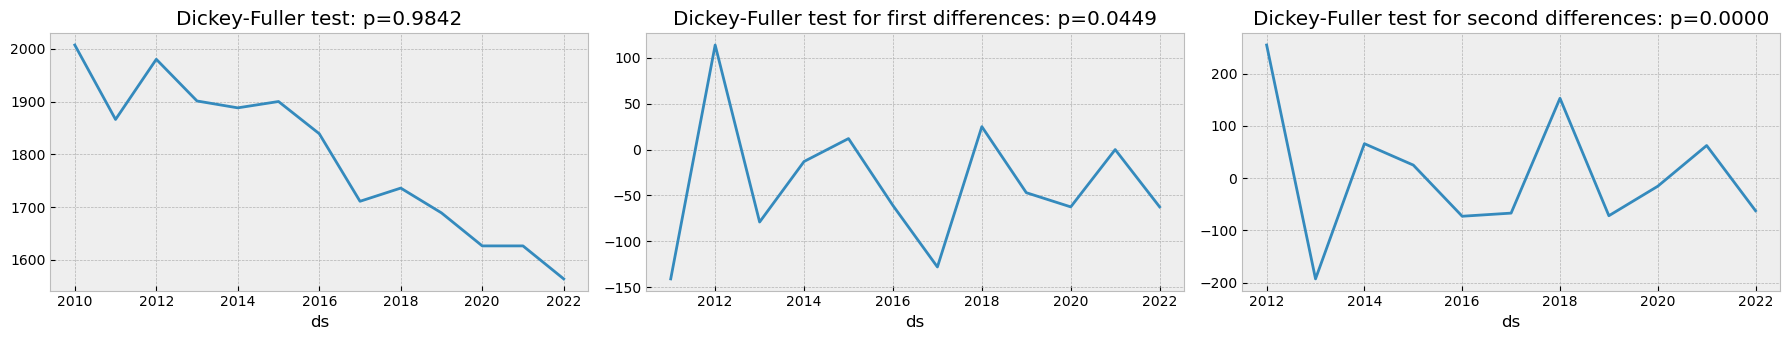

In [21]:
# Dickey — Fuller test
_, ax = plt.subplots(1,3, figsize = (18,3.5))
x1 = x
test_res = sm.tsa.stattools.adfuller(x1)
t = f"Dickey-Fuller test: p={test_res[1]:.4f}"# {test_res[0]:.4f}"
_ = x1.plot(title = t, ax = ax[0])

x1 = x.diff(1)[1:]
test_res = sm.tsa.stattools.adfuller(x1)
t = f"Dickey-Fuller test for first differences: p={test_res[1]:.4f}"# {test_res[0]:.4f}"
_ = x1.plot(title = t, ax = ax[1])

x1 = x.diff(1).diff(1)[2:]
test_res = sm.tsa.stattools.adfuller(x1)
t = f"Dickey-Fuller test for second differences: p={test_res[1]:.4f}"# {test_res[0]:.4f}"
_ = x1.plot(title = t, ax = ax[2])
plt.tight_layout()

### 2. ACF, PACF

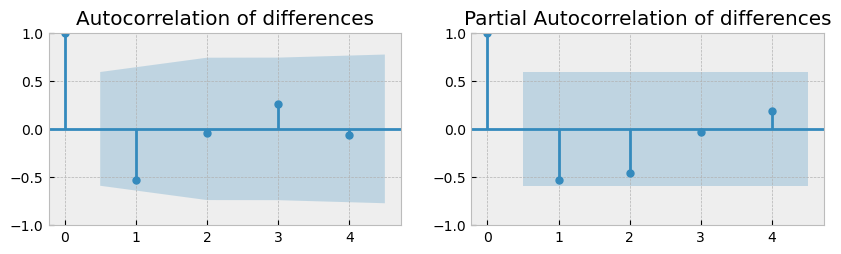

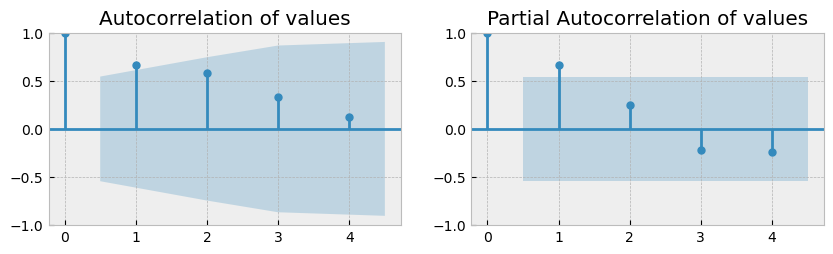

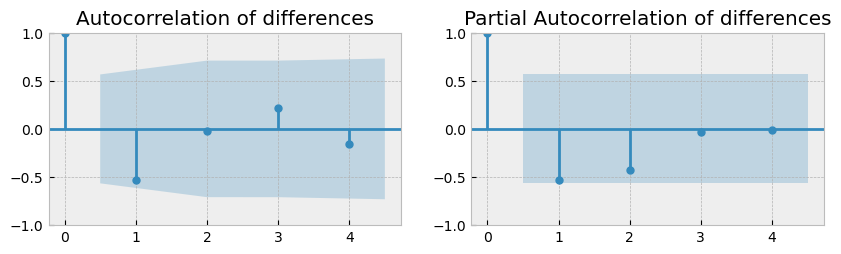

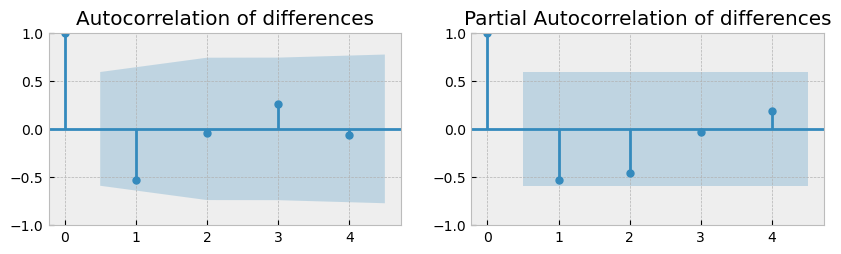

In [6]:
# Посмотрим на ACF и PACF полученного ряда:
l = 4
_, ax = plt.subplots(1,2, figsize = (10,2.5))
sm.graphics.tsa.plot_acf( x, lags=l, ax = ax[0], title = 'Autocorrelation of values')
sm.graphics.tsa.plot_pacf(x, lags=l, ax = ax[1], title = 'Partial Autocorrelation of values')

x1 = x.diff(1)[1:]
_, ax = plt.subplots(1,2, figsize = (10,2.5))
sm.graphics.tsa.plot_acf( x1, lags=l, ax = ax[0], title = 'Autocorrelation of differences')
sm.graphics.tsa.plot_pacf(x1, lags=l, ax = ax[1], title = 'Partial Autocorrelation of differences')

x1 = x.diff(1).diff(1)[2:]
_, ax = plt.subplots(1,2, figsize = (10,2.5))
sm.graphics.tsa.plot_acf( x1, lags=l, ax = ax[0], title = 'Autocorrelation of differences')
sm.graphics.tsa.plot_pacf(x1, lags=l, ax = ax[1], title = 'Partial Autocorrelation of differences')


### 3. Modeling

In [7]:
# SARIMAX searching
ps = range(0, 4) # by partial autocorr
ds = range(0, 3)
qs = range(0, 4) # by autocorr

parameters = itertools.product(ps, ds, qs, [0], [0], [0], [0])
parameters_list = list(parameters)
print(len(parameters_list))

48


In [8]:
n = len(x)
n1 = 2

In [9]:
%%time
list_param = []
list_res   = []
list_time  = []
list_pred  = []
import gc
import time

for p in parameters_list:
    t1 = time.time()
    list_res1 = list()
    list_pred1 = list()
    # train-valid split
    for k in range(1):
        train, valid = x[:-n1], x[-n1:]
        
        # train
        try:
            model_arima = sm.tsa.statespace.SARIMAX(train, order=(p[0],p[1],p[2]), seasonal_order=(p[3],p[4],p[5],p[6]))
            model_arima = model_arima.fit(disp=-1)
        except Exception as e:
            print(p, e)
            break
            
        # predict
        pred = model_arima.predict(start = 0, end = n - 1)
        pred = pred[-n1:]
        list_pred1 += list(pred)
        
        # evaluate
        res = ts_metrics(valid, pred)
        list_res1.append(res)
        
        del model_arima
        gc.collect()
        
        # break
        
    # collect
    if len(list_pred1) > 0:
        list_pred.append(list_pred1)
        list_res.append(pd.DataFrame(list_res1).mean())
        list_time.append({'time':time.time() - t1})
        list_param.append(p)

CPU times: total: 48.4 s
Wall time: 6.43 s


In [10]:
# results
df_out = pd.concat([
    pd.DataFrame(list_param, columns = ['p','d','q','P','D','Q','S']),
    pd.DataFrame(list_res),
    pd.DataFrame(list_time),
], axis = 1).sort_values('mae')
del df_out['P']
del df_out['D']
del df_out['Q']
del df_out['S']
del df_out['time']
df_out.reset_index(inplace = True)
del df_out['index']
df_out[:10]

,p,d,q,mae
0,2,2,0,4.79
1,3,2,1,8.18
2,3,1,1,9.92
3,1,2,1,10.16
4,2,1,1,11.50
5,2,2,1,11.72
6,0,2,2,14.27
7,0,2,3,15.52
8,3,2,0,18.31
9,3,2,3,18.75


In [11]:
# retrain best model
model_arima = sm.tsa.statespace.SARIMAX(x, order=(2,2,0), seasonal_order=(0,0,0,0))
model_arima = model_arima.fit(disp=-1)
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   13
Model:               SARIMAX(2, 2, 0)   Log Likelihood                 -61.559
Date:                Tue, 30 Jan 2024   AIC                            129.118
Time:                        23:29:16   BIC                            130.312
Sample:                             0   HQIC                           128.366
                                 - 13                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2020      0.206     -5.825      0.000      -1.606      -0.798
ar.L2         -0.7174      0.326     -2.198      0.028      -1.357      -0.078
sigma2      3713.6322   1795.127      2.069      0.039     195.249    7232.016
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 1.09
Prob(Q):                              0.66   Prob(JB):                         0.58
Heteroskedasticity (H):               0.28   Skew:                            -0.50
Prob(H) (two-sided):                  0.24   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

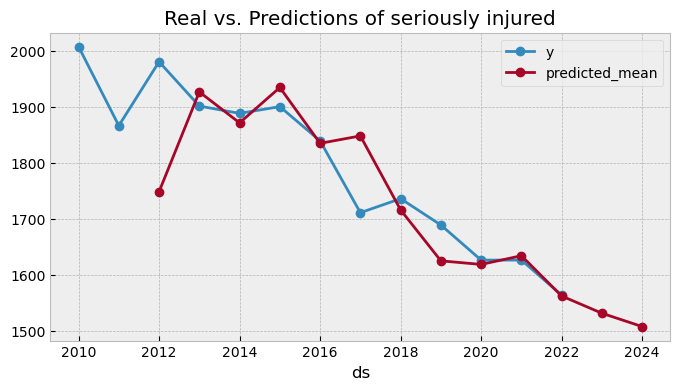

In [12]:
# make predictions
pred = model_arima.predict(start = 2, end = n + 1)
pred.index = pred.index + 2010
_ = x.plot(figsize = (8,4), style = 'o-', legend = 'real', title = 'Real vs. Predictions of seriously injured')
_ = pred.plot(figsize = (8,4), style = 'o-', legend = 'prediction')